<a href="https://colab.research.google.com/github/sombr3ro/Machine-Learning-Repo/blob/main/STL_10_supervised.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
from torch import nn
from torchvision.datasets import STL10
import numpy as np
import matplotlib.pyplot as plt
from torchvision.models import vgg16,resnet18
from torchvision.transforms import Compose,ToTensor,Normalize
from torch.utils.data import DataLoader
from torchsummary import summary
from torch.optim import SGD,Adam
from torch.nn import CrossEntropyLoss
from torchvision import transforms

In [ ]:
img_transform = Compose([
                         transforms.ColorJitter(0.2,0.2,0.2,0.2),
                         transforms.RandomAffine(10),
                         ToTensor(),
                         Normalize(mean= [0.485, 0.456, 0.406] , std = [0.229, 0.224, 0.225])
])

In [ ]:
train_df = STL10(root="train",split="train",transform=img_transform,download=True)
test_df = STL10(root="test", split="test", transform=img_transform, download=True)


Extracting train/stl10_binary.tar.gz to train



Extracting test/stl10_binary.tar.gz to test


In [ ]:
len(train_df.classes)

10

In [ ]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
device

device(type='cuda')

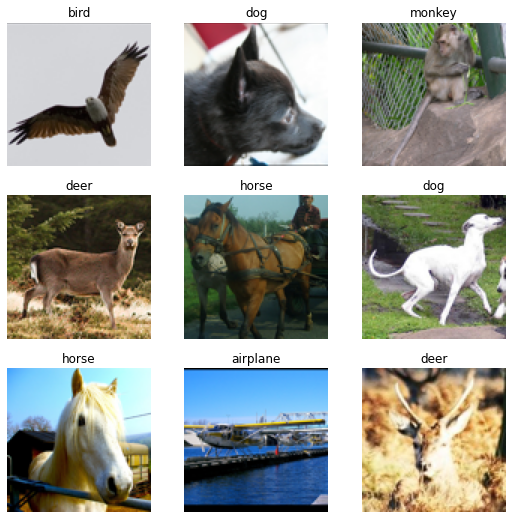

In [ ]:
rows = 3
cols = 3
fig,axs = plt.subplots(rows,cols, figsize=(9,9))
for i in range(rows):
  for j in range(cols):
    ax = axs[i][j]
    idx = np.random.randint(low=0,high=len(train_df))
    img = train_df.data[idx].transpose(1,2,0)
    label = train_df.labels[idx]
    ax.axis("off")

    ax.imshow(img)
    ax.set_title(train_df.classes[label])



In [ ]:
batch_size = 128
train_dl = DataLoader(train_df, batch_size=batch_size, shuffle=True)
test_dl = DataLoader(test_df, batch_size=batch_size, shuffle = True)

In [ ]:
model = vgg16(pretrained=False)

#for param in model.parameters():
#  param.requires_grad= False
model.classifier[3] = nn.Linear(4096,1024)
model.classifier[6] = nn.Linear(1024,10)
#model.classifier._modules['6'] = nn.Linear(4096,10)
#model.fc = nn.Linear(512,10)
model = model.to(device)
#model
summary(model,(3,96,96))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 96, 96]           1,792
              ReLU-2           [-1, 64, 96, 96]               0
            Conv2d-3           [-1, 64, 96, 96]          36,928
              ReLU-4           [-1, 64, 96, 96]               0
         MaxPool2d-5           [-1, 64, 48, 48]               0
            Conv2d-6          [-1, 128, 48, 48]          73,856
              ReLU-7          [-1, 128, 48, 48]               0
            Conv2d-8          [-1, 128, 48, 48]         147,584
              ReLU-9          [-1, 128, 48, 48]               0
        MaxPool2d-10          [-1, 128, 24, 24]               0
           Conv2d-11          [-1, 256, 24, 24]         295,168
             ReLU-12          [-1, 256, 24, 24]               0
           Conv2d-13          [-1, 256, 24, 24]         590,080
             ReLU-14          [-1, 256,

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


In [ ]:
optim = SGD(model.parameters(), lr = 1e-2, weight_decay=1e-4, momentum=0.9)
loss_fn = CrossEntropyLoss()

In [ ]:
def train(train_dl, loss_fn, optim):
  total_loss = 0.0
  total_acc = 0.0
  batch_size = train_dl.batch_size
  x_size=0.0
  for i,(x,y) in enumerate(train_dl):
    x = x.to(device)
    y = y.to(device)
    pred = model(x)
    loss = loss_fn(pred, y)

    loss_val = loss.item()
    accuracy = (pred.argmax(axis=1)==y).sum().item()
    x_size+= x.shape[0]

    total_loss+= loss_val
    total_acc+= accuracy

    optim.zero_grad()
    loss.backward()
    optim.step()
  
  total_acc = total_acc/x_size*100.0
  total_loss = total_loss/x_size
  return total_loss, total_acc
  

In [ ]:
def test(test_dl, loss_fn):
  total_loss = 0.0
  total_acc = 0.0
  x_size = 0

  model.eval()
  for x,y in test_dl:
    x = x.to(device)
    y = y.to(device)
    with torch.no_grad():
      pred = model(x)
      loss = loss_fn(pred, y)

      loss_val = loss.item()
      accuracy = (pred.argmax(axis=1)==y).sum().item()
      x_size+= x.shape[0]

      total_loss+= loss_val
      total_acc+= accuracy

  
  total_acc = total_acc/x_size*100.0
  total_loss = total_loss/x_size
  return total_loss, total_acc


In [ ]:
epoch = 100
test_loss =[]
test_acc =[]
train_loss=[]
train_acc=[]

In [ ]:
for e in range(epoch):
  print(f"epoch {e+1} begins -------------------------------------")
  loss,acc = train(train_dl,loss_fn,optim)
  train_loss.append(loss)
  train_acc.append(acc)
  print(f"Final accuracy:{acc} \t Loss:{loss}")

  loss,acc = test(test_dl,loss_fn)
  print(f"Test Dataset: Accuracy:{acc} \t Loss:{loss}")
  test_loss.append(loss)
  test_acc.append(acc)
print("Done---------------------------------------------")

epoch 1 begins -------------------------------------
Final accuracy:10.14 	 Loss:0.018387346935272216
Test Dataset: Accuracy:10.0 	 Loss:0.01797315648198128
epoch 2 begins -------------------------------------
Final accuracy:17.06 	 Loss:0.01766577968597412
Test Dataset: Accuracy:20.1125 	 Loss:0.016509422779083252
epoch 3 begins -------------------------------------
Final accuracy:25.540000000000003 	 Loss:0.015734845900535584
Test Dataset: Accuracy:29.349999999999998 	 Loss:0.014618037641048432
epoch 4 begins -------------------------------------
Final accuracy:28.26 	 Loss:0.014857485628128051
Test Dataset: Accuracy:33.45 	 Loss:0.013565538123250008
epoch 5 begins -------------------------------------
Final accuracy:31.119999999999997 	 Loss:0.01477150764465332
Test Dataset: Accuracy:29.762499999999996 	 Loss:0.014154614254832268
epoch 6 begins -------------------------------------
Final accuracy:34.5 	 Loss:0.013387652254104614
Test Dataset: Accuracy:31.8125 	 Loss:0.01391561190783

Text(0.5, 1.0, 'Accuracy vs iterations')

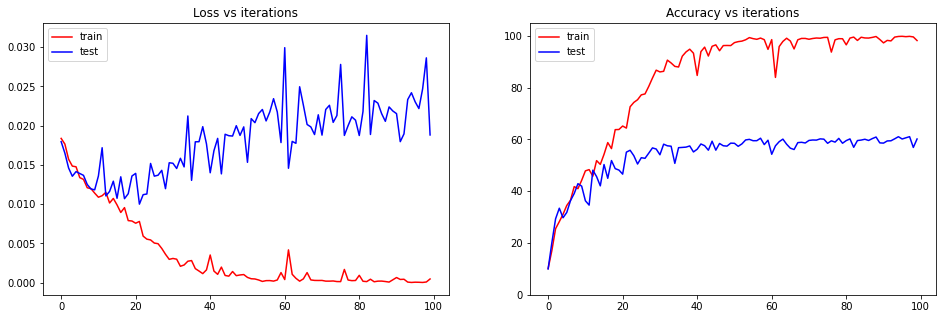

In [ ]:
fig,axs = plt.subplots(1,2, figsize=(16,5))
axs[0].plot(train_loss, color='red', label='train')
axs[0].plot(test_loss, color='blue', label = 'test')
axs[0].legend()
axs[0].set_title("Loss vs iterations")
axs[1].plot(train_acc, color='red', label='train')
axs[1].plot(test_acc, color='blue', label = 'test')
axs[1].set_ylim(ymin=0, ymax=105)
axs[1].legend()
axs[1].set_title("Accuracy vs iterations")

In [ ]:
torch.save(model.state_dict(),"./weights.bin")